# Classification exercises


This is a modified, more compact version of the SVM text classification code from the classification notebook. You may wish to use this as a starting point for doing some of the exercises.

(This first piece of code just imports the necessary libraries.)

In [1]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from eli5 import show_weights

## Loading and splitting data

In [2]:
#Amazon

import pandas as pd

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
text_data = pd.read_csv('reviews_balanced.csv', sep='\t', names=('class', 'text'))
text_data = text_data[['class', 'text']]   

print("Feature counts:")
print(class_counts(text_data))

#divide into train, devel and test sets
amazon_train_data, amazon_devel_and_test_data = train_test_split(text_data, test_size=0.4, random_state=1234)
amazon_devel_data, amazon_test_data = train_test_split(amazon_devel_and_test_data, test_size=0.5, random_state=5678)

amazon_train_Y, amazon_train_texts = amazon_train_data['class'], amazon_train_data['text']
amazon_devel_Y, amazon_devel_texts = amazon_devel_data['class'], amazon_devel_data['text']
amazon_test_Y, amazon_test_texts = amazon_test_data['class'], amazon_test_data['text']

print("\n", amazon_train_data[0:10])

Feature counts:
0    150035
4    149883

         class                                               text
286234      0  I have another version of "Cinderella", but I ...
62028       4  I love poverty to rich stories.  It's always i...
56510       4  Loved it. Fun look at an often difficult situa...
206997      0  It's funny...all of this antipathy towards the...
189629      0  This must be one of the latest entries in the ...
69346       4  I have long enjoyed watching crows.  This book...
216626      0  I went out and bought this book after seeing t...
36200       4  Great, safe and nice looking bumper!  I would ...
205937      0  The author attempts to paint some trends from ...
17334       4  There are lots of lists, the book is well orga...


In [3]:
#Sentiment 140

import pandas as pd

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
text_data = pd.read_csv('../data/sentiment140.csv', sep='\t', names=('class', 'id', 'time', 'query', 'user', 'tweet'))
text_data = text_data[['class', 'tweet']]   

print("Feature counts:")
print(class_counts(text_data))

#divide into train, devel and test sets
s140_train_data, s140_devel_and_test_data = train_test_split(text_data, test_size=0.4, random_state=1234)
s140_devel_data, s140_test_data = train_test_split(s140_devel_and_test_data, test_size=0.5, random_state=5678)

s140_train_Y, s140_train_texts = s140_train_data['class'], s140_train_data['tweet']
s140_devel_Y, s140_devel_texts = s140_devel_data['class'], s140_devel_data['tweet']
s140_test_Y, s140_test_texts = s140_test_data['class'], s140_test_data['tweet']



print("\n", s140_train_data[0:10])

Feature counts:
4    800000
0    800000

          class                                              tweet
1063187      4  i wish i had a balloon t-shirt. maybe i shall ...
7089         0  @ddlovato hey demi, wen are you and selena gon...
633572       0   i think the huge bug bite the size of a large...
1019991      4  slept in too late. lots to do, little time to ...
438271       0                          Re: chocos. Its all over 
14104        0  so we never went to softball. o well haha. han...
479775       0  @itshanni3  I felt sorry for the guy though be...
254598       0         @Virkus Duck!  this makes me miss my duck.
796035       0  My family are little shite-ers. Including Daddy. 
1114592      4  Goin back to work next week, so not looking fo...


## Featurization and vectorization

In [4]:
#Amazon
space_tokenizer = lambda text: text.split()

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(amazon_train_texts)
amazon_train_X = vectorizer.transform(amazon_train_texts)
amazon_devel_X = vectorizer.transform(amazon_devel_texts)
amazon_test_X = vectorizer.transform(amazon_test_texts)
s140_test_X = vectorizer.transform(s140_test_texts)

In [5]:
#Sentiment140
space_tokenizer = lambda text: text.split()

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(s140_train_texts)
s140_train_X = vectorizer.transform(s140_train_texts)
s140_devel_X = vectorizer.transform(s140_devel_texts)
s140_test_X = vectorizer.transform(s140_test_texts)

In [5]:
#Distribution of texts and classes in the datasets

#Amazon
print("Amazon")
print("Train:", len(amazon_train_texts))
print(class_counts(amazon_train_data), "\n")

print("Devel:",len(amazon_devel_texts))
print(class_counts(amazon_devel_data), "\n")

print("Test:",len(amazon_test_texts))
print(class_counts(amazon_test_data))



Amazon
Train: 179950
0    89986
4    89964 

Devel: 59984
0    30211
4    29773 

Test: 59984
4    30146
0    29838


In [6]:
#Distribution of texts and classes in the datasets

#Amazon
print("Sentiment140")
print("Train:", len(s140_train_texts))
print(class_counts(s140_train_data), "\n")

print("Devel:",len(s140_devel_texts))
print(class_counts(s140_devel_data), "\n")

print("Test:",len(s140_test_texts))
print(class_counts(s140_test_data), "\n")

Sentiment140
Train: 960000
4    480309
0    479691 

Devel: 320000
0    160171
4    159829 

Test: 320000
0    160138
4    159862 



## Training and prediction

In [11]:
#Amazon
from sklearn import metrics

#train_results = []
#devel_results = []
amazon_results = []

for c in (0.001, 0.01, 0.1, 1): #10, 100 out, need for speed
    classifier = LinearSVC(C=c, class_weight=None, max_iter=100000, loss="squared_hinge")
    classifier.fit(amazon_train_X, amazon_train_Y)
    amazon_pred_train = classifier.predict(amazon_train_X)
    amazon_pred_devel = classifier.predict(amazon_devel_X)
    print("C: ",c, "\tTrain: ", metrics.f1_score(amazon_train_Y, amazon_pred_train, pos_label=4), "\tDevel: ", metrics.f1_score(amazon_devel_Y, amazon_pred_devel, pos_label=4))
    amazon_results.append({"C": c, "Train F": metrics.f1_score(amazon_train_Y, amazon_pred_train, pos_label=4), "Devel F": metrics.f1_score(amazon_devel_Y, amazon_pred_devel, pos_label=4)})

C:  0.001 	Train:  0.7755387201711679 	Devel:  0.7628176326693625
C:  0.01 	Train:  0.8423235586758935 	Devel:  0.8236507158432074
C:  0.1 	Train:  0.9450299314338636 	Devel:  0.8905556872439132
C:  1 	Train:  0.9990163879765933 	Devel:  0.9169370100027033


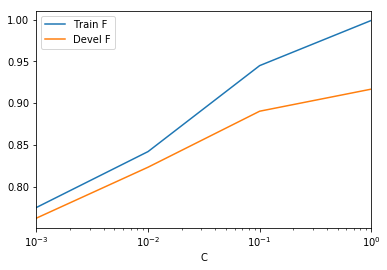

In [13]:
from pandas import DataFrame
DataFrame(amazon_results).plot(x='C', y=["Train F", 'Devel F'], logx=True)

In [13]:
#Sentiment140
from sklearn import metrics

s140_results = []

for c in (0.001, 0.01, 0.1, 1, 10, 100): #10, 100 out, need for speed
    classifier = LinearSVC(C=c, class_weight=None, max_iter=100000, loss="squared_hinge")
    classifier.fit(s140_train_X, s140_train_Y)
    s140_pred_train = classifier.predict(s140_train_X)
    s140_pred_devel = classifier.predict(s140_devel_X)
    print("C:",c, "\tTrain:", metrics.f1_score(s140_train_Y, s140_pred_train, pos_label=4), "\tDevel:", metrics.f1_score(s140_devel_Y, s140_pred_devel, pos_label=4))
    s140_results.append({"C": c, "Train F": metrics.f1_score(s140_train_Y, s140_pred_train, pos_label=4), "Devel F": metrics.f1_score(s140_devel_Y, s140_pred_devel, pos_label=4)})

C: 0.001 	Train: 0.7520559940539417 	Devel: 0.7402416779949956
C: 0.01 	Train: 0.8063732525435299 	Devel: 0.7892842235424454
C: 0.1 	Train: 0.8817813090514833 	Devel: 0.8160837556832643
C: 1 	Train: 0.9900633547300896 	Devel: 0.8176369512098999
C: 10 	Train: 0.9982202866494424 	Devel: 0.8042226062997847
C: 100 	Train: 0.9985786476431062 	Devel: 0.7913716366579


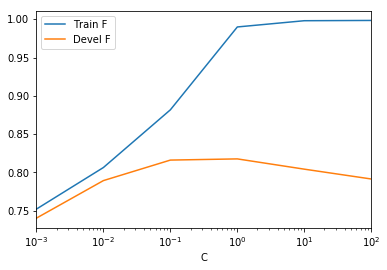

In [16]:
from pandas import DataFrame
DataFrame(s140_results).plot(x='C', y=["Train F", 'Devel F'], logx=True)

# Milestone II

In [9]:
#Sentiment140 - vectorize to fit amazon

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(amazon_train_texts)
s140_test_X = vectorizer.transform(s140_test_texts)

In [10]:
%%time
classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=100000,
    loss='squared_hinge'
)
classifier.fit(amazon_train_X, amazon_train_Y)

CPU times: user 11.5 s, sys: 140 ms, total: 11.6 s
Wall time: 11.6 s


In [11]:
%%time

amazon_pred_train = classifier.predict(amazon_train_X)
amazon_pred_test = classifier.predict(amazon_test_X)
s140_pred_test = classifier.predict(s140_test_X)

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 301 ms


## Evaluation and analysis

In [12]:
accuracy = accuracy_score(amazon_train_Y, amazon_pred_train) 
tn, fp, fn, tp = confusion_matrix(amazon_train_Y, amazon_pred_train, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)
print("Train: Amazon, Test: Amazon (training data)")
print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score),"\n")



Train: Amazon, Test: Amazon (training data)
accuracy 99.90%
precision 99.89%, recall 99.91%, f-score 99.90% 



In [13]:
accuracy = accuracy_score(amazon_test_Y, amazon_pred_test) 
tn, fp, fn, tp = confusion_matrix(amazon_test_Y, amazon_pred_test, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)
print("Train: Amazon, Test: Amazon (test data)")
print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score),"\n")


Train: Amazon, Test: Amazon (test data)
accuracy 91.90%
precision 92.15%, recall 91.70%, f-score 91.93% 



In [14]:
accuracy = accuracy_score(s140_test_Y, s140_pred_test) 
tn, fp, fn, tp = confusion_matrix(s140_test_Y, s140_pred_test, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)
print("Train: Amazon, Test: Sentiment140")
print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score))

Train: Amazon, Test: Sentiment140
accuracy 62.15%
precision 60.80%, recall 68.24%, f-score 64.31%


In [16]:
classAndPrediction = list(zip(s140_test_Y, s140_pred_test, s140_test_texts))
incorrect = []
for i in classAndPrediction:
    if i[0] != i[1]:
        incorrect.append(i)

tn, fp, fn, tp = confusion_matrix(amazon_test_Y, amazon_pred_test, labels=[4, 0]).ravel()
        
print("Incorrect predictions:", len(incorrect), "/", len(classAndPrediction))

fps = []
fns = []
for i in range (1, 40): 
    if incorrect[i][1] == 4:
        if len(fps) != 15:
            fps.append(incorrect[i])
    else:
        if len(fns) != 15:
            fns.append(incorrect[i])

print("\nFalse positives: ", fp)
for i in fps:
    print(i)
print("\n")

print("False negatives: ", fn)
for i in fns:
    print(i)

Incorrect predictions: 121115 / 320000

False positives:  2501
(0, 4, '@djbroc gah! hearted and downloaded - love it! unfortch, my real job has taken over my far more important job of hypemhearting ')
(0, 4, '@MarkYoung_ yup  and my back is already killing me from gardening yesterday doh!')
(0, 4, "had a fun night with the girls! Can't wait for Friday...and it's only Monday ")
(0, 4, "Still so Icky. Ugh. WTF?!?! My stomach hurts Soooo bad! I'm glad I went home.  hope I feel better soon")
(0, 4, 'On da way to CTW to get that top !poor me ')
(0, 4, 'Feeling &quot;sexxay&quot; is important to me, @FunyGrl.  But lately I feel that way maybe 5% of the time.  ')
(0, 4, '@jovian0401  im following you now! understand this website  although i really do not u')
(0, 4, 'I want to go home ')
(0, 4, "Ugly Betty's finale was  MATT.  But Henry Grubstick is still adorable as he was before! Chris Gorham is &lt;3333")
(0, 4, 'Finished with dinner but a little upset that orlando lost to boston ')
(0, 4, 

In [36]:
show_weights(classifier, vec=vectorizer)

# Milestone III

In [50]:
#Translated data

import pandas as pd

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
text_data = pd.read_csv('translations.csv', sep='\t', names=('class', 'text'))
text_data = text_data[['class', 'text']]   

print("Feature counts:")
print(class_counts(text_data))

#divide into train, devel and test sets
train_data, devel_and_test_data = train_test_split(text_data, test_size=0.4, random_state=1234)
devel_data, test_data = train_test_split(devel_and_test_data, test_size=0.5, random_state=5678)

train_Y, train_texts = train_data['class'], train_data['text']
devel_Y, devel_texts = devel_data['class'], devel_data['text']
test_Y, test_texts = test_data['class'], test_data['text']


print("\n", train_data[0:10])

Feature counts:
4    1000
0    1000

       class                                               text
387       0   OK, olen juuri päättynyt kuunnellen C.D. Pred...
808       0   Kirjoittaja kirjoittaa negatiivisia kommentte...
128       0   Aloitin koko sarjan muutama vuosi sitten, kun...
1393      4   Tämä on tyypillinen J-Walk kirja, jossa on pa...
398       0   Olen yleensä suuri fani kirjoja lapsille, ja ...
1934      4   Ensinnäkin haluan sanoa, että olen valtava Se...
1612      4   Varmasti aihe materiaali on mielenkiintoinen....
470       0   Tämä näyttää Shot-on-video alhaisen budjetin ...
674       0   Tämä oli nopea lukea, mutta se olisi voitu ki...
1295      4   Ystäväni kertoi minulle tämä kirja on uskomat...


In [62]:
#Finnish data

import pandas as pd
import random

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
finnish_data = pd.read_csv('verkkokauppa.csv', sep='\t', names=('class', 'text'))
finnish_data = finnish_data[['class', 'text']]   

fin_data, useless_data = train_test_split(finnish_data, test_size=1, random_state=1234)

print("Feature counts:")
print(class_counts(fin_data))

finnish_Y, finnish_texts = fin_data['class'], fin_data['text']


print("\n", fin_data[0:10])

Feature counts:
4    108
0     94

      class                                               text
159      0  Turha ostos,Kuvittelin, että Surface Pron ja L...
31       4  meikkipeili. ostin tyttärelle lahjaksi tämän j...
48       4  Hyvin toimiva tuote. Asentaminen onnistui aika...
63       4  Helppo ja huomaamaton Tämä F-Securen SAFE on n...
59       4  Kaikki samassa. Tuotteen ehdotton hyvä puoli o...
5        4  Yksinkertaisen näköinen kapistus, mutta yllätt...
7        0  Ei sovi minulle. Tuote ei auta minua ollenkaan...
187      4  Laadukas tabletti upealla näytöllä,Ostin tämän...
110      4  Suosittelen. Kyseisellä tuotteella saimme sydä...
197      0  Ei toimi auton käydessä,Ostin aiemmin saman va...


In [63]:
#Amazon
space_tokenizer = lambda text: text.split()

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(train_texts)
train_X = vectorizer.transform(train_texts)
devel_X = vectorizer.transform(devel_texts)
#test_X = vectorizer.transform(test_texts)
finnish_X = vectorizer.transform(finnish_texts)

In [65]:
#Distribution of texts and classes in the dataset

print("Train:", len(train_texts))
print(class_counts(train_data), "\n")

print("Devel:",len(devel_texts))
print(class_counts(devel_data), "\n")

print("Test:",len(test_texts))
print(class_counts(test_data), "\n")

print("Test (Finnish):",len(finnish_texts))
print(class_counts(fin_data), "\n")

Train: 1200
0    602
4    598 

Devel: 400
0    204
4    196 

Test: 400
4    206
0    194 

Test (Finnish): 202
4    108
0     94 



In [66]:
from sklearn import metrics

train_results = []
devel_results = []
results = []

for c in (0.001, 0.01, 0.1, 1, 10, 100):
    classifier = LinearSVC(C=c, class_weight=None, max_iter=100000, loss="squared_hinge")
    classifier.fit(train_X, train_Y)
    pred_train = classifier.predict(train_X)
    #train_results.append({ 'C': c, 'F1': metrics.f1_score(train_Y, pred, pos_label=4), 'Precision': metrics.precision_score(train_Y,pred, pos_label=4), 'Recall': metrics.recall_score(train_Y,pred, pos_label=4)})
    pred_devel = classifier.predict(devel_X)
    #devel_results.append({ 'C': c, 'F1': metrics.f1_score(devel_Y, pred, pos_label=4), 'Precision': metrics.precision_score(devel_Y,pred, pos_label=4), 'Recall': metrics.recall_score(devel_Y,pred, pos_label=4)})
    print("C: ",c, "\tTrain: ", metrics.f1_score(train_Y, pred_train, pos_label=4), "\tDevel: ", metrics.f1_score(devel_Y, pred_devel, pos_label=4))
#    results.append({"C": c, "Train F": metrics.f1_score(train_Y, pred_train, pos_label=4), "Devel F": metrics.f1_score(devel_Y, pred_devel, pos_label=4)})

C:  0.001 	Train:  0.03934426229508197 	Devel:  0.0
C:  0.01 	Train:  0.6050605060506051 	Devel:  0.12957746478873242
C:  0.1 	Train:  0.6870095902353968 	Devel:  0.21994884910485935
C:  1 	Train:  0.6965342349957734 	Devel:  0.2239185750636132
C:  10 	Train:  0.7000835421888053 	Devel:  0.21428571428571427
C:  100 	Train:  0.701082431307244 	Devel:  0.20971867007672634


In [67]:
%%time
classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=100000,
    loss='squared_hinge'
)
classifier.fit(train_X, train_Y)

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 25.4 ms


In [68]:
%%time
pred_test = classifier.predict(test_X)
pred_finnish = classifier.predict(finnish_X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.03 ms


In [46]:
#Metrics for translated test set

accuracy = accuracy_score(test_Y, pred_test) 
tn, fp, fn, tp = confusion_matrix(test_Y, pred_test, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)


print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score))

accuracy 16.00%
precision 16.84%, recall 16.02%, f-score 16.42%


In [69]:
#Metrics for Verkkokauppa test set

accuracy = accuracy_score(finnish_Y, pred_finnish) 
tn, fp, fn, tp = confusion_matrix(finnish_Y, pred_finnish, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)


print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score))

accuracy 51.49%
precision 55.68%, recall 45.37%, f-score 50.00%


In [71]:
classAndPrediction = list(zip(test_Y, pred_test, test_texts))
incorrect = []
for i in classAndPrediction:
    if i[0] != i[1]:
        incorrect.append(i)

tn, fp, fn, tp = confusion_matrix(test_Y, pred_test, labels=[4, 0]).ravel()
        
print("Incorrect predictions:", len(incorrect), "/", len(classAndPrediction))

fps = []
fns = []
for i in range (1, 40): 
    if incorrect[i][1] == 4:
        if len(fps) != 15:
            fps.append(incorrect[i])
    else:
        if len(fns) != 15:
            fns.append(incorrect[i])

print("\nFalse positives: ", fp)
for i in fps:
    print(i)
print("\n")

print("False negatives: ", fn)
for i in fns:
    print(i)

Incorrect predictions: 336 / 400

False positives:  173
(0, 4, ' Joten olin aallokko net... kuunnellen itsemurha kuninkaat taustalla.... Ajattelu... Okei joten olen juuri voittanut Young Indian Jones kaupan käynti kortti asettaa... Mitä muuta minun pitäisi saada, että on Sean Patrick Flannery siinä! HA!  Tässä mennään... elokuvan BRITNEY MURPHY samoin-Pisteet! Hyvin... Olin Valitettavasti Valitettavasti... hyvin järkyttynyt, että olen maksanut tämän paljon rahaa elokuvan IMI tämän huonosti.... Jos pidät omituinen musta komeukset... Tämä elokuva on sinua varten... mutta ei minulle! Sean Patrick Flannery ajaa ympäriinsä hänen wifes luuranko... Britney Murphy aiheuttaa hänen sulhanen tappaa itsensä, koska hän ei halua naida häntä.... se kaikki vain IMI...  Sean vaikka... on edelleen tietenkin seksikäs seksikäs! ja niin on brtney Murphy-mutta luulen, että hän näyttää paremmalta kuin ohut vaalea.. kuin vauva rasvaa brunette...",')
(0, 4, ' Anil on muovia-jos hän on mitään herkkyyttä tai kul

In [70]:
classAndPrediction = list(zip(finnish_Y, pred_finnish, finnish_texts))
incorrect = []
for i in classAndPrediction:
    if i[0] != i[1]:
        incorrect.append(i)

tn, fp, fn, tp = confusion_matrix(finnish_Y, pred_finnish, labels=[4, 0]).ravel()
        
print("Incorrect predictions:", len(incorrect), "/", len(classAndPrediction))

fps = []
fns = []
for i in range (1, 40): 
    if incorrect[i][1] == 4:
        if len(fps) != 15:
            fps.append(incorrect[i])
    else:
        if len(fns) != 15:
            fns.append(incorrect[i])

print("\nFalse positives: ", fp)
for i in fps:
    print(i)
print("\n")

print("False negatives: ", fn)
for i in fns:
    print(i)

Incorrect predictions: 98 / 202

False positives:  59
(0, 4, 'Eivät toimi langattomasti,Jos kuulokkeissa on bluetooth -ominaisuus, voisi äkkiä kuvitella niissä olevan myös langaton kuuntelumahdollisuus. Vaan eipä ole. Kuulokkeissa on kuitenkin irrallinen usb-johto, jonka kuulokkeiden päässä oleva micro usb -liitäntä on erittäin altis vikaantumiselle. Miksi irrallinen johto, jos se on kerran välttämätön kuulokkeiden käyttämiseksi? ')
(0, 4, 'Ihan OK, mutta... ...ei ole mielestäni täyden hintansa arvoinen. Onneksi oli alennuksessa ostaessani. Ei sovi mielestäni pienelle lapselle (ostaessani lapseni oli puolitoista vuotias). Kypärälle ei ole syvennystä ja vyöt ovat liian heppoiset, joten lapsi valahtaa helposti huonoon asentoon. Isommalle lapselle olisi passelimpi... mutta, kärry on sen verran pieni, että kovin iso lapsi ei kypärä päässä mahdu kyytiin. Kärryssä ei ole jousitusta, joten huonommassa maastossa ei varmastikaan ole kiva istua kyydissä. Satunnaiseen käyttöön sopiva ja ehkä esim